# Matriz Getis Ord Brasil

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/matriz_getis_ord_brasil.ipynb`

## Bibliotecas

In [1]:
#!pip install geopandas==0.8.1
#!pip install --upgrade pyshp
#!pip install shapely==1.7.0
#!pip install --upgrade descartes
#!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
#!pip install esda

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans, AgglomerativeClustering

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [3]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [5]:
dados18 = pd.read_csv(link+'/seguro18.csv',
                      encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [6]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [7]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [8]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [9]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [10]:
dados.reset_index(level = 0, inplace = True)

In [11]:
dados.shape

(2293, 9)

In [12]:
dados = dados.merge(cod, on='mun')

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
# seguro = pd.read_csv(link_p+'seguroagricola2017.csv', encoding='latin1') # troquei para 2018
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
# apolices = seguro.groupby('nome_mun').apolices_contratadas.sum()
# apolices = pd.DataFrame(apolices).reset_index()

In [19]:
dados_br = cod_dados.merge(seguro, how='left')

In [20]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

In [21]:
# dados_br.to_csv(r'/home/walef/Dropbox/Mestrado/Dados/dados_multi_spati_teste.csv',index=False, header= True)

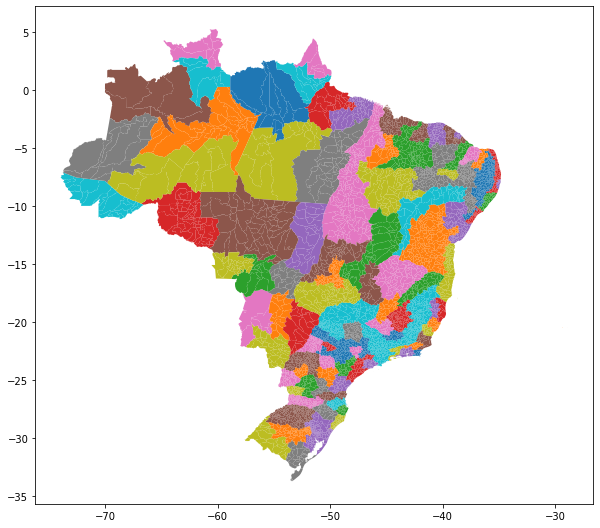

In [22]:
# dados_br.plot(column='apolices', figsize=(10, 10), scheme='quantiles', cmap='OrRd', legend=True, k=4);
dados_br.plot(column='nome_meso', figsize=(10, 10)); # , cmap='OrRd',  cmap='plasma'

## Matriz de G de Getis-Ord


Teste de construção de uma matriz de G de Getis-Ord para cada variável


### Criando a matriz

In [23]:
getis_matrix = dados_br

In [24]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # , 'geometry'
getis_matrix = getis_matrix.drop(retirar, axis = 1)

### G de Getis-Ord local para variáveis

In [25]:
getis_matrix.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [26]:
# demora um pouco
w = Queen.from_dataframe(dados_br)
w.transform = 'r'

In [27]:
for variavel in getis_matrix.drop(['nome_mun', 'geometry'], axis = 1).columns:
    getis_matrix[variavel] = G_Local(dados_br[variavel].values, w).Zs

In [28]:
getis_matrix = getis_matrix.set_index('nome_mun')

In [29]:
getis_matrix.describe()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
count,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000
mean,0.040838,0.050734,0.041679,0.041599,0.027134,0.035894,0.040489,0.022450
std,0.812388,0.760717,0.720193,0.722840,0.743226,0.838645,0.892232,0.774895
min,-0.277323,-0.290448,-0.245294,-0.245084,-0.189393,-0.323527,-0.386128,-0.182899
25%,-0.276994,-0.290206,-0.245044,-0.245031,-0.189393,-0.323388,-0.385102,-0.181931
50%,-0.250084,-0.257785,-0.226538,-0.226142,-0.189393,-0.323388,-0.323006,-0.181931
75%,-0.056141,0.004312,-0.033086,-0.034221,-0.098093,-0.026315,0.001515,-0.110195
max,10.444671,8.245047,10.584698,10.259288,16.994864,7.221352,6.488244,17.554673


### Mapa G de Getis-Ord

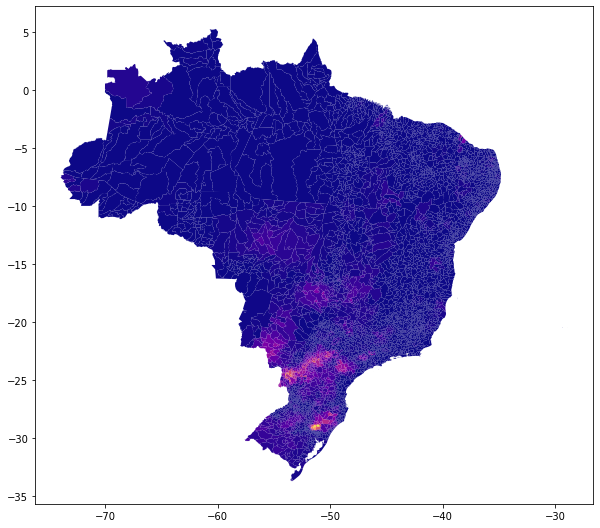

In [30]:
getis_matrix.plot(column='apolices_contratadas', figsize=(10, 10), cmap = 'plasma'); # , cmap='OrRd'

## Análise de agrupamento - G de Getis-Ord

In [31]:
# subselecionar variáveis
X = getis_matrix.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [32]:
Z = linkage(X, method='ward')

In [33]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

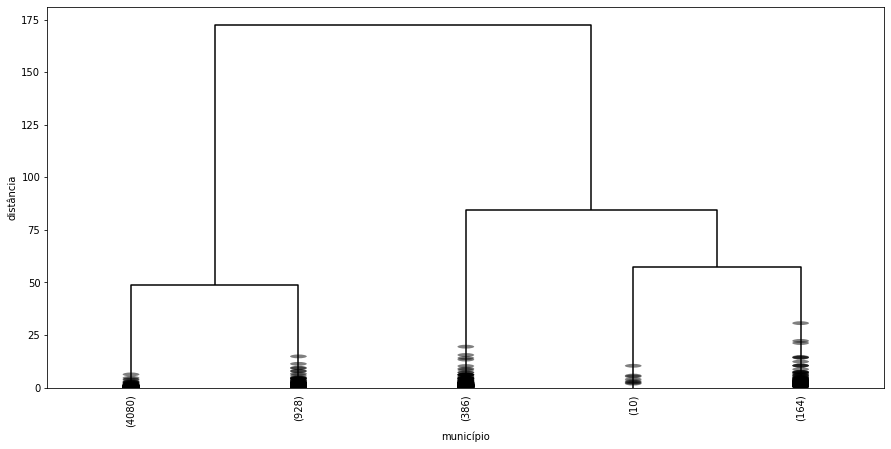

In [34]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [35]:
Z = linkage(X, method='ward')

In [36]:
# definir a distância de corte baseando no dendrograma
max_d = 40
grupos = cut_tree(Z, height=max_d)

### Métricas

In [37]:
#retirar = ['uf', 'nome_uf', 'mun', 'nome_mun', 'meso', 'nome_meso', 'micro',
#       'nome_micro', 'codmun6', 'regiao', 'nome_regiao', 'geometry',] # 
#dados_metrics = dados_br.drop(retirar, axis = 1)
dados_metrics = getis_matrix.drop('geometry', axis=1)

In [38]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics.values, grupos.ravel(), metric='euclidean'),2)  
)

4659.99 1.05 0.65


In [39]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
getis_matrix['grupo'] = grupos
# moran_matrix.head(2)

In [40]:
# contagem de observações em cada grupo
getis_matrix.grupo.value_counts()

0    4080
1     928
2     386
4      88
3      76
5      10
Name: grupo, dtype: int64

In [41]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
getis_matrix.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
grupo,,,,,,,,
0,-0.239194,-0.239269,-0.213440,-0.213574,-0.177159,-0.284952,-0.315827,-0.171935
1,0.167822,0.258108,0.164060,0.162403,0.088524,0.302525,0.337318,0.038341
2,1.154613,1.287301,1.110776,1.098060,0.769181,1.443635,1.697587,0.706918
3,2.341966,3.658296,3.752700,3.726991,2.372340,1.779738,1.842761,1.323426
4,3.911890,2.326871,2.276090,2.354539,2.383073,3.940639,4.209874,3.443404
5,7.963940,3.948760,3.639575,3.798983,10.482968,4.243870,3.519593,11.444352


In [42]:
# mediana das variáveis para cada grupo
getis_matrix.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
grupo,,,,,,,,
0,-0.271612,-0.285499,-0.243385,-0.243319,-0.189393,-0.323388,-0.379226,-0.181931
1,0.079949,0.201243,0.110752,0.109858,-0.002397,0.186686,0.256376,-0.029300
2,1.048103,1.146015,1.040148,1.027720,0.637963,1.142773,1.498463,0.428619
3,2.361790,3.381616,3.176037,3.113604,2.120094,1.667404,1.650575,1.096388
4,3.693796,2.166868,2.181832,2.282072,2.076658,4.138940,4.305606,2.930017
5,7.775493,4.312029,3.793793,3.897888,9.277235,4.732203,3.410508,9.932141


### As observações de cada grupo

In [43]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos G de Getis Ord

In [44]:
getis_matrix['grupo'] = getis_matrix['grupo'].astype('category')

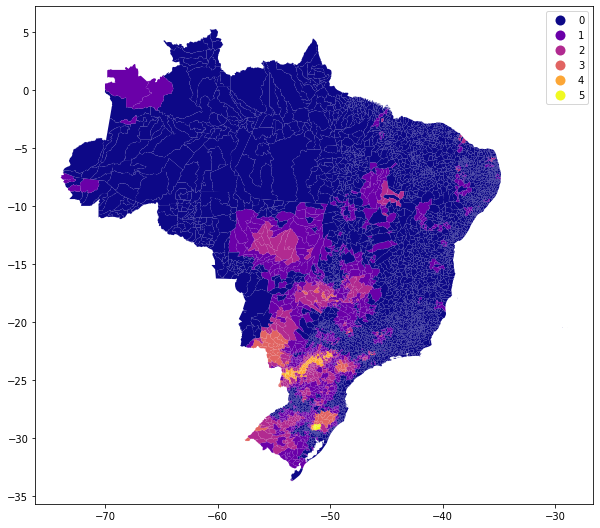

In [45]:
getis_matrix.plot(column='grupo', figsize=(10, 10), legend=True, cmap = 'plasma'); # , cmap='OrRd'

## K-Médias - G de Getis-Ord

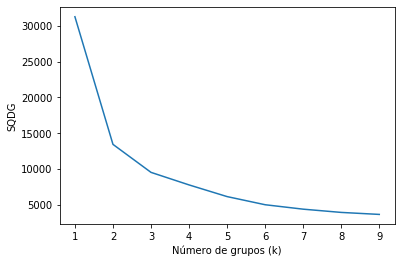

In [46]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(getis_matrix.drop('geometry', axis=1))
    getis_matrix['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [47]:
k = 3

In [48]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [49]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
getis_matrix['grupo'] = kmeans.labels_

### Métricas

In [50]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics.values, kmeans.labels_, metric='euclidean'),2)  
)

6204.54 0.9 0.76


In [51]:
# contagens
getis_matrix.grupo.value_counts()

0    4827
2     564
1     177
Name: grupo, dtype: int64

In [52]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [53]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
getis_matrix.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,-0.187784,-0.174894,-0.165810,-0.166203,-0.146022,-0.211375,-0.229602,-0.147174,0.845245
1,3.533527,2.849957,2.852377,2.900842,2.746705,3.258270,3.466799,3.078630,3.920904
2,0.901386,1.103294,0.935397,0.922752,0.655609,1.140869,1.276786,0.515057,2.785461


In [54]:
# mediana das variáveis para cada grupo
getis_matrix.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,-0.265030,-0.275468,-0.237576,-0.237263,-0.189393,-0.323388,-0.355516,-0.181931,1
1,3.175929,2.592426,2.458054,2.532599,2.077474,3.346876,3.645637,2.516075,2
2,0.758998,0.929202,0.804487,0.809347,0.459584,0.918019,1.099730,0.311137,4


In [55]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com G de Getis Ord 

In [56]:
getis_matrix['grupo'] = getis_matrix['grupo'].astype('category')

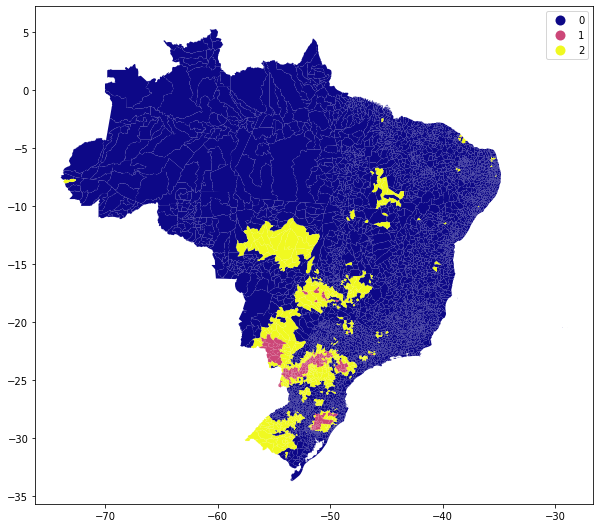

In [57]:
getis_matrix.plot(column='grupo', figsize=(10, 10), legend=True, cmap = 'plasma'); # , cmap='OrRd'